# Cell Count Notebook

In [9]:
import pandas as pd
import numpy as np
import anndata as ad

for i in range(10):
    PATH_replogle = f"/hpc/projects/group.califano/GLM/data/cellxgene/data/replogle_clean_partitioned/rep{i}/cells.h5ad"
    rep = ad.read_h5ad(PATH_replogle)
    if i == 0:
        value_counts = rep.obs["gene_id"].value_counts()[2:]
    else:
        value_counts += rep.obs["gene_id"].value_counts()[2:]

SyntaxError: invalid syntax (3916824509.py, line 5)

In [ ]:
value_counts = rep.obs["gene_id"].value_counts()[2:]

In [3]:
value_counts = rep.obs["gene_id"].value_counts()
value_counts

gene_id
non-targeting      7454
nan                 306
ENSG00000100316     197
ENSG00000158828     171
ENSG00000130829     147
                   ... 
ENSG00000105402       1
ENSG00000182054       1
ENSG00000137266       1
ENSG00000031698       1
ENSG00000107960       1
Name: count, Length: 9818, dtype: int64

In [4]:
value_counts.median()

18.0

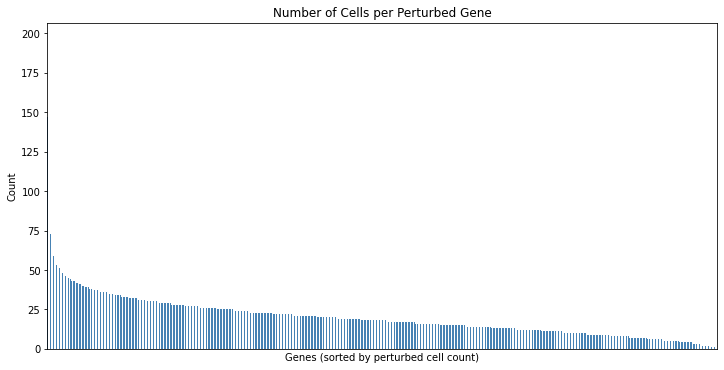

In [8]:
import matplotlib.pyplot as plt

# Count occurrences
value_counts = rep.obs["gene_id"].value_counts()[2:]

# Plot the top 20 most frequent gene IDs
plt.figure(figsize=(12, 6))
value_counts.plot(kind="bar", color="steelblue")

plt.xlabel("Genes (sorted by perturbed cell count)")
plt.ylabel("Count")
plt.title("Number of Cells per Perturbed Gene")
plt.xticks([])
plt.show()


In [2]:
prt_dataset = rep
gene_ids = prt_dataset.obs.gene_id

In [3]:
gene_to_node = pd.read_csv("/hpc/projects/group.califano/GLM/data/cellxgene_gene2index.csv", index_col=0)
included_ENSG = gene_to_node.index[2:]
included_ENSG

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000288602', 'ENSG00000288611', 'ENSG00000288642',
       'ENSG00000288649', 'ENSG00000288675', 'ENSG00000288701',
       'ENSG00000288702', 'ENSG00000288705', 'ENSG00000288709',
       'ENSG00000288722'],
      dtype='object', name='gene_name', length=19244)

In [4]:
gene_id="gene_id"

gene_to_node = pd.read_csv("/hpc/projects/group.califano/GLM/data/cellxgene_gene2index.csv", index_col=0)
INCLUDED_ENSG = gene_to_node.index[2:]

prt_dataset = ad.read("/hpc/projects/group.califano/GLM/data/cellxgene/data/replogle_clean_partitioned/rep1/cells.h5ad", backed="r") # Get perturbation dataset - only raw/un-binned expression data is used for perturbation
assert all(prt_dataset.var.index.isin(INCLUDED_ENSG)) # Make sure ALL the genes (columns) in the dataset are genes we are able to tokenize

# Below, any cells where gene_id is 'nan' are discarded
gene_ids = prt_dataset.obs[gene_id] # Get the perturbed gene ids
control_mask = (gene_ids == "non-targeting") # Mask accounting for cells with non-targeting intervention
perturbed_mask = gene_ids.isin(prt_dataset.var.index).to_numpy() # Mask accounting for cells with perturbed genes that are included in our dataset

control_cells = prt_dataset[control_mask] # Get the control cells from the perturbation dataset
perturbed_cells = prt_dataset[perturbed_mask] # Get the perturbed cells from the perturbation dataset

print("Number of control cells:", control_cells.shape[0])
print("Number of perturbed cells:", perturbed_cells.shape[0])


/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/scllm/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Number of control cells: 7454
Number of perturbed cells: 147797


In [45]:
# Create one-hot vectors for each perturbed cell -> '1' corresponds to perturbed gene
perturbations = perturbed_cells.obs["gene_id"].reset_index(drop=True) # Series object of perturbation for each cell (after filtering cells)
one_hot_perturbations = np.zeros((perturbed_cells.shape), dtype=int)  # Initialize one-hot matrix with all zero
for i, gene in enumerate(perturbations):
    one_hot_perturbations[i, perturbed_cells.var.index.get_loc(gene)] = 1 # Set "1" in appropriate positions

In [8]:
perturbed_cells.var.index.get_loc("ENSG00000127054")

9

In [ ]:
# assert same column order

In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import torch

PATH_replogle = "/hpc/projects/group.califano/GLM/data/perturbation/replogle/train/control/rep1_0.pt"
# rep = ad.read_h5ad(PATH_replogle)
rep = torch.load(PATH_replogle)

FileNotFoundError: [Errno 2] No such file or directory: '/hpc/projects/group.califano/GLM/data/perturbation/replogle/train/control/rep1_0.pt'

In [12]:
e = rep.edge_index[:, :40000]
w = rep.edge_weight[:40000]

In [13]:
rep.edge_index = e
rep.edge_weight = w

In [14]:
torch.save(rep, "/hpc/projects/group.califano/GLM/data/perturbation/replogle/test.pt")

In [9]:
PATH_replogle = "/hpc/projects/group.califano/GLM/data/cxg_cache_4096_META/train/astrocyte_0.pt"
# rep = ad.read_h5ad(PATH_replogle)
adata = torch.load(PATH_replogle)

In [10]:
adata

Data(x=[7657, 2], edge_index=[2, 38762], edge_weight=[38762])

In [6]:
rep.edge_index

tensor([[18365, 18365, 18365,  ...,  3672,  3672,  3672],
        [16864, 15256,  6261,  ...,  3489,  8757,   211]])

In [10]:
import os
import random
import shutil
from tqdm import tqdm

source_dir='/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed'
dest_dir='/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed'

os.makedirs("/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed/train", exist_ok=True)
os.makedirs("/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed/val", exist_ok=True)
os.makedirs("/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed/test", exist_ok=True)

data = os.listdir("/hpc/projects/group.califano/GLM/data/single_cell/replogle_cache/perturbed")

random.shuffle(data)

val = 0.2
test = 0.1

# Compute sample sizes
n_total = len(data)
n_20 = int(n_total * val)
n_10 = int(n_total * test)

# Sample 20%
val_20 = data[:n_20]

# Sample 10% from remaining data
test_10 = data[n_20:n_20 + n_10]

# Sample 10% from remaining data
train_70 = data[n_20 + n_10:]

for filename in tqdm(val_20):
    src_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(f"{dest_dir}/val", filename)
    
    try:
        shutil.move(src_path, dest_path)
    except:
        print(f"Failed: {filename}")


for filename in tqdm(test_10):
    src_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(f"{dest_dir}/test", filename)
    
    try:
        shutil.move(src_path, dest_path)
    except:
        print(f"Failed: {filename}")

for filename in tqdm(train_70):
    src_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(f"{dest_dir}/train", filename)
    
    try:
        shutil.move(src_path, dest_path)
    except:
        print(f"Failed: {filename}")

print("DONE")
del data


 21%|██▏       | 20249/95288 [00:54<05:29, 227.47it/s]

Failed: train


100%|██████████| 95288/95288 [04:21<00:00, 364.49it/s]

DONE


## Find where cells are being lost

In [6]:
import os
import pandas as pd
import numpy as np
import anndata as ad
from scGraphLLM import quantize_cells

ImportError: cannot import name 'preprocess' from 'scGraphLLM' (unknown location)

In [2]:
adata = ad.read("/hpc/projects/group.califano/GLM/data/_cellxgene/data/tmp2/cells.h5ad")
adata

/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/cellxgene/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 37053 × 19221
    obs: 'index', 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'index', 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_count

## Troubleshoot Replogle File Size

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix

n = 1000

In [2]:
cxg = ad.read("/hpc/projects/group.califano/GLM/data/_replogle/partitions10/split_2.h5ad")
# cxg = cxg[:n].to_memory()
cxg


/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/cellxgene/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10000 × 7948
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [3]:
cxg.obs

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,core_scale_factor,core_adjusted_UMI_count
cell_barcode,,,,,,,,,,,
AAAGGATGTTGTCAGT-89,89,PTP4A3,ENSG00000184489,P1P2,6921_PTP4A3_P1P2_ENSG00000184489,PTP4A3_+_142402180.23-P1P2|PTP4A3_+_142402153....,0.126987,10190.0,-0.562970,1.090165,9347.207031
AAAGGATGTTGTCTAG-228,228,TMEM74B,ENSG00000125895,P1P2,9096_TMEM74B_P1P2_ENSG00000125895,TMEM74B_+_1166518.23-P1P2|TMEM74B_+_1166498.23...,0.134360,21048.0,1.554104,1.114371,18887.785156
AAAGGATGTTGTGCAT-249,249,HPCAL1,ENSG00000115756,P1P2,3930_HPCAL1_P1P2_ENSG00000115756,HPCAL1_-_10443062.23-P1P2|HPCAL1_-_10443073.23...,0.099632,19000.0,1.328323,1.113379,17065.167969
AAAGGATGTTGTGCAT-41,41,LIN54,ENSG00000189308,P2,4594_LIN54_P2_ENSG00000189308,LIN54_+_83931965.23-P2|LIN54_+_83931898.23-P2,0.075351,15368.0,-0.463861,1.582352,9712.125000
AAAGGATGTTGTGGCC-77,77,TPM1,ENSG00000140416,P1,9203_TPM1_P1_ENSG00000140416,TPM1_-_63335121.23-P1|TPM1_+_63335017.23-P1,0.124711,19485.0,0.275997,1.484751,13123.416992
...,...,...,...,...,...,...,...,...,...,...,...
AAATGGACATCCGTTC-149,149,SDHC,ENSG00000143252,P1P2,7727_SDHC_P1P2_ENSG00000143252,SDHC_+_161284139.23-P1P2|SDHC_-_161284228.23-P1P2,0.148038,6755.0,0.544841,0.480401,14061.184570
AAATGGACATCCGTTC-150,150,TGFBR3,ENSG00000069702,P1P2,8861_TGFBR3_P1P2_ENSG00000069702,TGFBR3_+_92351649.23-P1P2|TGFBR3_+_92351639.23...,0.095715,12694.0,1.595963,0.700655,18117.341797
AAATGGACATCCTCAC-179,179,PPARG,ENSG00000132170,P2,6610_PPARG_P2_ENSG00000132170,PPARG_-_12329531.23-P2|PPARG_+_12329450.23-P2,0.123330,8984.0,-1.467873,1.472080,6102.930176


In [6]:
a = cxg.obs.gem_group.unique()
a.sort()
a

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [3]:
import torch

data = torch.load("/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/club_cell_146.pt")
data

Data(x=[1924, 2], edge_index=[2, 6680], edge_weight=[6680])

In [25]:
data.x[:, 1] #.min()

tensor([31, 31, 31,  ..., 85, 31, 89])

In [43]:
cxg.write("/hpc/projects/group.califano/GLM/data/_replogle/cxg_test.h5ad")
rep.write("/hpc/projects/group.califano/GLM/data/_replogle/rep_test.h5ad")

In [15]:
import pandas as pd

a = pd.read_csv("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_meta_cell_clean/club_cell_TEST/binned_expression.csv")
a

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286522,ENSG00000288705,ENSG00000287080,ENSG00000288642,ENSG00000288702,ENSG00000286920,ENSG00000287363,ENSG00000288675,ENSG00000287542,ENSG00000288558
0,1,0,0,73,0,0,0,33,71,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,33,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,64,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,36,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,35,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,64,34,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,32,1,32,0,...,0,0,0,0,0,0,0,0,0,0
8,85,0,0,0,0,0,31,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,86,0,0,0,0,0,1,1,34,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
b = a.head(20)
b

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286522,ENSG00000288705,ENSG00000287080,ENSG00000288642,ENSG00000288702,ENSG00000286920,ENSG00000287363,ENSG00000288675,ENSG00000287542,ENSG00000288558
0,1,0,0,73,0,0,0,33,71,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,33,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,64,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,36,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,35,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,64,34,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,32,1,32,0,...,0,0,0,0,0,0,0,0,0,0
8,85,0,0,0,0,0,31,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,86,0,0,0,0,0,1,1,34,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
b.to_csv("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_meta_cell_clean/club_cell_TEST/binned_expression.csv", index=False)

In [1]:
import pandas as pd

# gene_to_node = pd.read_csv("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_single_cell_clean/acinar_cell/binned_expression.csv")
# gene_to_node


# Count rows efficiently (skip header)
row_count = sum(1 for _ in open("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_single_cell_clean/acinar_cell/binned_expression.csv")) - 1

# Get column count by reading just the header
col_count = len(pd.read_csv("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_single_cell_clean/acinar_cell/binned_expression.csv", nrows=1).columns)

print(f"Rows: {row_count}, Columns: {col_count}")

: 

In [9]:
gene_to_node.idx = gene_to_node.idx - 2

In [11]:
gene_to_node

,gene_name,idx
0,<PAD>,-2
1,<MASK>,-1
2,ENSG00000000003,0
3,ENSG00000000005,1
4,ENSG00000000419,2
...,...,...
19241,ENSG00000288701,19239
19242,ENSG00000288702,19240
19243,ENSG00000288705,19241
19244,ENSG00000288709,19242


In [12]:
gene_to_node.to_csv("/hpc/projects/group.califano/GLM/data/cellxgene_gene2index.csv")

In [1]:
a = [
    [1, 2, 3],
    [4, 3, 2]
]

In [4]:
pd.DataFrame(a, columns=["a", "b", "c"])

,a,b,c
0,1,2,3
1,4,3,2


In [12]:
import torch.nn as nn

# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding(input)


tensor([[[-0.6964, -1.3807, -0.0415],
         [-0.0571, -0.1273,  0.7683],
         [ 0.0111, -0.5835, -1.2511],
         [ 0.3208,  0.5633, -0.3765]],

        [[ 0.0111, -0.5835, -1.2511],
         [-0.3628,  1.9408, -0.3385],
         [-0.0571, -0.1273,  0.7683],
         [ 0.2035, -2.5540, -1.4024]]], grad_fn=<EmbeddingBackward0>)

In [21]:
embedding(torch.LongTensor([2, -1]))

IndexError: index out of range in self

In [19]:
# Get the embedding matrix (shape: [10, 5])
embedding_matrix = embedding.weight.data
embedding_matrix

tensor([[ 0.9167,  0.5214,  0.3438],
        [-0.6964, -1.3807, -0.0415],
        [-0.0571, -0.1273,  0.7683],
        [-0.3628,  1.9408, -0.3385],
        [ 0.0111, -0.5835, -1.2511],
        [ 0.3208,  0.5633, -0.3765],
        [-1.7447, -0.1608,  0.8146],
        [-1.0180, -0.0668,  0.5616],
        [-0.5504,  1.4073,  1.7789],
        [ 0.2035, -2.5540, -1.4024]])

In [2]:
import anndata as ad
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

cts = pd.read_csv("/hpc/projects/group.califano/cell_types.csv")
DATASET_PATH = "/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_meta_cell_clean/"
n_list = []
for ct in tqdm(cts["PROCESSED_CELL_TYPES"]):
    ct_path = os.path.join(DATASET_PATH, ct, "metacells.h5ad")
    adata = ad.read(ct_path)

    num_unique_bins = []
    for cell in adata[:1000]:  
        num_unique_bins.append(np.unique(cell.X.toarray()).shape[0])
    num_unique_bins = np.array(num_unique_bins)
    
    n_list.append([ct, num_unique_bins.mean(), num_unique_bins.std(), adata.shape[0], adata.shape[1]])
    del num_unique_bins
    del adata

In [1]:
import torch

t = torch.load("/hpc/projects/group.califano/GLM/data/single_cell/replogle_140k/control/test/K562_4.pt")
t

Data(x=[7948, 2], edge_index=[2, 2519123], edge_weight=[2519123])

In [3]:
t.x[:, 1].unique()

tensor([ 0,  4,  5,  6,  7,  8,  9, 10])

In [1]:
import anndata as ad

a = ad.read('/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_200k_clean/K562/cells.h5ad', backed="r")
a

/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/cellxgene/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 199954 × 7948 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_200k_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
a.X[0].toarray()

array([[0.      , 4.274324, 0.      , ..., 8.845416, 0.      , 0.      ]],
      dtype=float32)

In [3]:
import anndata as ad

expression = ad.read("/hpc/projects/group.califano/GLM/data/_replogle/data/reduced_replogle.h5ad", backed="r")
expression

AnnData object with n_obs × n_vars = 698546 × 4000 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/reduced_replogle.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [4]:
perturbation_var = "gene_id"
# Below, any cells where perturbation_var is 'nan' - or the perturbed gene is not in the column genes - are discarded
gene_ids = expression.obs[perturbation_var] # Get the perturbed gene ids
control_mask = (gene_ids == "non-targeting") # Mask accounting for cells with non-targeting intervention
perturbed_mask = gene_ids.isin(expression.var.index).to_numpy() # Mask accounting for cells with perturbed genes that are included in our dataset

In [5]:
control_cells = expression[control_mask] # Get the control cells from the perturbation dataset
perturbed_cells = expression[perturbed_mask] # Get the perturbed cells from the perturbation dataset
perturbation_ENSGs = perturbed_cells.obs[perturbation_var].reset_index(drop=True)

print("Number of control cells:", control_cells.shape[0])
print("Number of perturbed cells:", perturbed_cells.shape[0])

Number of control cells: 75328
Number of perturbed cells: 623218


In [6]:
perturbation_ENSGs

0         ENSG00000178104
1         ENSG00000143553
2         ENSG00000004534
3         ENSG00000005100
4         ENSG00000196584
               ...       
623213    ENSG00000119285
623214    ENSG00000101464
623215    ENSG00000160352
623216    ENSG00000033867
623217    ENSG00000140319
Name: gene_id, Length: 623218, dtype: category
Categories (4000, object): ['ENSG00000000419', 'ENSG00000001084', 'ENSG00000001497', 'ENSG00000001629', ..., 'ENSG00000279170', 'ENSG00000280789', 'ENSG00000284024', 'ENSG00000285053']

In [8]:
import numpy as np

prt_masks = np.zeros_like(expression.obs["gene_id"], dtype=bool)
for prt in perturbation_ENSGs.unique():
    mask = expression.obs["gene_id"] == prt
    mask_array = np.asarray(mask)
    
    # Get indices where mask is True
    true_indices = np.where(mask_array)[0]

    # Set all to False initially
    new_mask = np.zeros_like(mask_array, dtype=bool)

    # Set first 50 True values
    new_mask[true_indices[:50]] = True
    
    prt_masks = prt_masks | new_mask    

In [17]:
prt_masks.sum()

192674

In [20]:
control_mask.sum()

75328

In [18]:
prt_masks = prt_masks | control_mask

In [19]:
prt_masks.sum()

268002

In [39]:
trimmed_expression = expression[prt_masks, :]
trimmed_expression

View of AnnData object with n_obs × n_vars = 192674 × 4000 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_raw/K562/partitions/reduced_replogle.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

In [40]:
trimmed_expression.write("/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_raw/K562/partitions/trimmed_replogle.h5ad")

In [21]:
expression.shape

(698546, 4000)

In [2]:
import anndata as ad

a = ad.read("/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_clean/K562/cells.h5ad", backed="r")
a

/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/cellxgene/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 267225 × 4000 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
import pandas as pd

gene_to_node = pd.read_csv("/hpc/projects/group.califano/GLM/data/cellxgene_gene2index.csv")
INCLUDED_ENSG = gene_to_node.index[2:]

global_gene_to_node = {row.gene_name:row.idx for _,row in gene_to_node.iterrows()}

In [22]:
global_gene_to_node

{'<PAD>': 0,
 '<MASK>': 1,
 'ENSG00000000003': 2,
 'ENSG00000000005': 3,
 'ENSG00000000419': 4,
 'ENSG00000000457': 5,
 'ENSG00000000460': 6,
 'ENSG00000000938': 7,
 'ENSG00000000971': 8,
 'ENSG00000001036': 9,
 'ENSG00000001084': 10,
 'ENSG00000001167': 11,
 'ENSG00000001460': 12,
 'ENSG00000001461': 13,
 'ENSG00000001497': 14,
 'ENSG00000001561': 15,
 'ENSG00000001617': 16,
 'ENSG00000001626': 17,
 'ENSG00000001629': 18,
 'ENSG00000001630': 19,
 'ENSG00000001631': 20,
 'ENSG00000002016': 21,
 'ENSG00000002330': 22,
 'ENSG00000002549': 23,
 'ENSG00000002586': 24,
 'ENSG00000002587': 25,
 'ENSG00000002726': 26,
 'ENSG00000002745': 27,
 'ENSG00000002746': 28,
 'ENSG00000002822': 29,
 'ENSG00000002834': 30,
 'ENSG00000002919': 31,
 'ENSG00000002933': 32,
 'ENSG00000003056': 33,
 'ENSG00000003096': 34,
 'ENSG00000003137': 35,
 'ENSG00000003147': 36,
 'ENSG00000003249': 37,
 'ENSG00000003393': 38,
 'ENSG00000003400': 39,
 'ENSG00000003402': 40,
 'ENSG00000003436': 41,
 'ENSG00000003509': 4

In [4]:
import anndata as ad

expression = ad.read("/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_clean/K562/cells.h5ad", backed="r")
expression

/hpc/mydata/leo.dupire/anaconda/23.1.0-3/x86_64/envs/cellxgene/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 267225 × 4000 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
expression.var.index

Index(['ENSG00000055332', 'ENSG00000259494', 'ENSG00000179632',
       'ENSG00000165983', 'ENSG00000166848', 'ENSG00000065518',
       'ENSG00000120539', 'ENSG00000082146', 'ENSG00000044115',
       'ENSG00000136450',
       ...
       'ENSG00000182512', 'ENSG00000136111', 'ENSG00000187735',
       'ENSG00000143033', 'ENSG00000109685', 'ENSG00000129347',
       'ENSG00000133773', 'ENSG00000165678', 'ENSG00000062582',
       'ENSG00000204899'],
      dtype='object', name='gene_id', length=4000)

In [ ]:
assert all(expression.var.index.isin(INCLUDED_ENSG))

In [8]:
expression.var.index.shape

(4000,)

In [12]:
import numpy as np
np.where(~(expression.var.index.isin(INCLUDED_ENSG)))[0]

array([2542, 3223])

In [15]:
expression.var.index[3223]

'ENSG00000177946'

In [23]:
expression[:, expression.var_names.isin(global_gene_to_node)]

View of AnnData object with n_obs × n_vars = 267225 × 3998 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_reduced_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [39]:
# x = expression.var.index[~(expression.var.index.isin(global_gene_to_node))]
expression[:, expression.var_names.isin(global_gene_to_node)]
expression.obs["gene_id"].isin(global_gene_to_node)

191949

In [38]:
(expression.obs["gene_id"] != "non-targeting").sum()

192049

In [42]:
191949 - 192049

-100

In [55]:
import torch

t = torch.load("/hpc/projects/group.califano/GLM/data/single_cell/replogle_reduced/perturbed/train/K562_2_0.pt")
t

Data(x=[3998, 2], edge_index=[2, 908836], edge_weight=[908836], perturbation=3192)

In [56]:
t.x

tensor([[7.4500e+02, 0.0000e+00],
        [1.8658e+04, 5.0455e+00],
        [1.4216e+04, 5.0455e+00],
        ...,
        [1.1449e+04, 6.1398e+00],
        [8.3900e+02, 5.0455e+00],
        [1.7201e+04, 5.4488e+00]])

In [ ]:
node_expression = torch.tensor(np.array([(global_gene_to_node[gene], cell[gene]) for gene in cell.index]), dtype=torch.float16)

In [1]:
from scGraphLLM.data import *
from torch.nn.utils.rnn import pad_sequence

In [2]:
def collate_fn(batch):
    data = { 
            "orig_gene_id" : [], 
            "orig_expression_id" : [], 
            "expression_mask" : [], 
            "edge_index": [], 
            "num_nodes" :[], 
            "dataset_name" : []
    }
    
    # Make a dictionary of lists from the list of dictionaries
    for cell in batch:
        for key in data.keys():
            data[key].append(cell[key])

    # Pad these dictionaries of lists
    for key in data.keys():
        if (key == "dataset_name") or (key == "edge_index") or (key == "num_nodes"):
            continue
        elif key == "orig_gene_id":
            pad_value = PAD_GENE_IDX
        elif key == "orig_expression_id":
            pad_value = PAD_EXPRESSION_IDX
        elif key == "expression_mask":
            pad_value = False
        data[key] = pad_sequence(data[key], batch_first=True, padding_value=pad_value)

    return data

In [4]:
import torch
import torch.nn as nn

class Config(dict):
    def __getattr__(self, item):
        try:
            return self[item]
        except KeyError:
            raise AttributeError(f"Attribute {item} not found")
    def __setattr__(self, key, value):
        self[key] = value
    def __delattr__(self, item):
        try:
            del self[item]
        except KeyError:
            raise AttributeError(f"Attribute {item} not found")

In [10]:
data_config = Config({
                "train": Config({"cache_dir":"/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train", "dataset_name": "train"}),
                "val": [
                    Config({"cache_dir":"/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/valHOG", "dataset_name":"valHOG"})
                    ],
                "test": [
                    ],
                "run_test":False, 
                "num_workers": 1,
                "batch_size": 8
            })

In [13]:
transformer_data_module = GraphTransformerDataModule(data_config, collate_fn=collate_fn)
train_transformer_dl = transformer_data_module.train_dataloader()

Cache Directory: /hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train
Observation Count: 2,223,173
Cache Directory: /hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/valHOG
Observation Count: 446,420


In [14]:
for ex in train_transformer_dl:
    # print(ex)
    break

/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/t_cell_20966.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/cd16-positive_cd56-dim_natural_killer_cell_human_29875.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/naive_b_cell_25736.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/cd16-negative_cd56-bright_natural_killer_cell_human_6169.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/luminal_adaptive_secretory_precursor_cell_of_mammary_gland_6575.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/cerebellar_granule_cell_2624.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/type_ii_pneumocyte_4393.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/gabaergic_amacrine_cell_15952.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/cerebellar_granule_cell_8738.pt
/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train/intestinal_epithelial_c

: 

In [1]:
import os

cache_dir = '/hpc/projects/group.califano/GLM/data/meta_cell/cxg_4096/train'
os.listdir(cache_dir)

['t_cell_20966.pt',
 'cd16-positive_cd56-dim_natural_killer_cell_human_29875.pt',
 'naive_b_cell_25736.pt',
 'cd16-negative_cd56-bright_natural_killer_cell_human_6169.pt',
 'luminal_adaptive_secretory_precursor_cell_of_mammary_gland_6575.pt',
 'cerebellar_granule_cell_2624.pt',
 'type_ii_pneumocyte_4393.pt',
 'gabaergic_amacrine_cell_15952.pt',
 'cerebellar_granule_cell_8738.pt',
 'intestinal_epithelial_cell_5368.pt',
 'dendritic_cell_1607.pt',
 'cd14-positive_monocyte_3022.pt',
 'cd14-positive_monocyte_14462.pt',
 'natural_killer_cell_100319.pt',
 'neural_cell_73242.pt',
 'enterocyte_14250.pt',
 'oligodendrocyte_precursor_cell_11236.pt',
 'b_cell_19837.pt',
 't_cell_43275.pt',
 'neural_cell_24938.pt',
 'endothelial_cell_of_vascular_tree_17064.pt',
 'gabaergic_amacrine_cell_3562.pt',
 'cd4-positive_alpha-beta_t_cell_52459.pt',
 'vip_gabaergic_cortical_interneuron_20321.pt',
 'basal_cell_9824.pt',
 'cerebral_cortex_gabaergic_interneuron_7092.pt',
 'unknown_118468.pt',
 'cd14-positive_mo

In [1]:
import os
import anndata as ad

ad.read_h5ad("/hpc/projects/group.califano/GLM/data/_cellxgene/data/cxg_HOG_subset/retinal_rod_cell/cells.h5ad")

AnnData object with n_obs × n_vars = 1000 × 19221
    obs: 'index', 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'index', 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts